# 통신사 고객 이탈 예측 

### 목적
* 파악한 특성들을 이용하여 기대 가치가 큰 고객의 이탈 징후를 잘 탐지하는 예측 모델 생성.
[참고](https://brunch.co.kr/@gimmesilver/53)
    - 예측 모델의 목표는 오차를 최소화하는 것이 아니다.
        - 실제 서비스에서 예측 모델을 사용하는 본질적인 목적은 정답을 잘 맞추겠다가 아니라 예측 모델을 실전에 적용함으로써 이익을 얻는 것. 
        - 따라서, 실제 예측 모델이 목표로 해야할 것은 오차를 최소화하는 것이 아니라 모델 적용을 통해 기대되는 이익을 최대화하는 것. 
        
### 문제 정의
* 지도학습, 분류

### 성능 지표
* 재현율
    * 실제 이탈하는 사람 중 이탈이라고 예측하는 것이 중요하기 때문.
    * 실제 이탈하지 않은 사람을 이탈이라고 예측하면 회사 측에서 손해액 발생

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder  # 더미변수 생성 
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # 분류
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns


In [2]:
pd.set_option('display.max_columns', 500)

df = pd.read_csv("../../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.shape

(7043, 21)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"],errors = "coerce")

In [6]:
df.select_dtypes(include=[np.object]).describe()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,3815-SLMEF,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [7]:
df.select_dtypes(include=[np.number]).describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>],
       [<AxesSubplot:title={'center':'TotalCharges'}>, <AxesSubplot:>]],
      dtype=object)

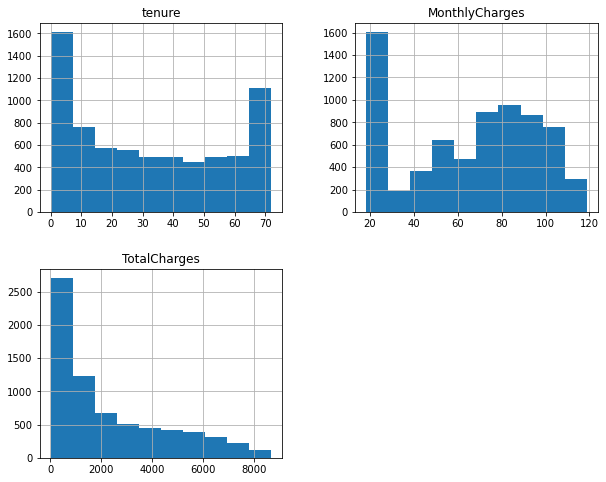

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(figsize = (10,8),bins = 10)

In [9]:
df = df[df["tenure"]!=0].reset_index(drop=True)

<AxesSubplot:>

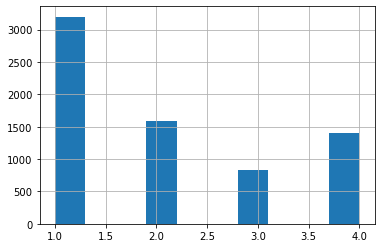

In [10]:
df["tenure_cat"] = pd.cut(df["tenure"], bins = [0, 24,48,60,72], labels = [1,2,3,4])
df["tenure_cat"].hist()

In [11]:
df["tenure_cat"].value_counts()

1    3199
2    1594
4    1407
3     832
Name: tenure_cat, dtype: int64

In [12]:
df["tenure_cat"].isnull().sum()

0

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 20171490)

for train_index, test_index in split.split(df, df["tenure_cat"]):
    X_train = df.loc[train_index]
    X_test = df.loc[test_index]

In [14]:
X_train["tenure_cat"].value_counts()/len(X_train)

1    0.454933
2    0.226667
4    0.200000
3    0.118400
Name: tenure_cat, dtype: float64

In [15]:
X_test["tenure_cat"].value_counts()/len(X_test)

1    0.454869
2    0.226724
4    0.200426
3    0.117982
Name: tenure_cat, dtype: float64

In [16]:
for set_ in (X_train, X_test):
    set_.drop("tenure_cat",axis = 1, inplace = True)

In [17]:
X_train

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3131,3884-HCSWG,Female,0,No,No,17,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.00,1144.50,Yes
1353,9272-LSVYH,Male,0,No,No,10,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,70.15,735.50,No
3866,7340-KEFQE,Female,0,Yes,Yes,51,No,No phone service,DSL,Yes,No,No,Yes,No,No,Two year,No,Bank transfer (automatic),34.20,1782.00,No
5814,9867-NNXLC,Female,0,No,No,22,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,470.20,No
3578,9552-TGUZV,Male,0,Yes,No,8,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,75.00,658.10,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3027,5696-EXCYS,Male,0,No,No,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.45,369.05,No
314,7563-BIUPC,Male,0,No,No,5,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.60,415.55,Yes
887,7549-MYGPK,Female,0,Yes,Yes,63,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,100.55,6215.35,Yes
3926,5396-IZEPB,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.70,180.70,No


In [18]:
data = X_train.copy()

In [19]:
data['Churn_b'] = data['Churn'].astype('category').cat.rename_categories([0,1])

In [20]:
from scipy import stats

# Convert attrition to numeric
num_features = list(data.select_dtypes(include=[np.number]))

# Point Biserial Correlation table
pb_list = []
print("Significant Point Biserial Correlations")
print("{0:23} |   {1:4}|  {2:}".format("Factor", "r", "p"))
for i in num_features:
    r, p = stats.pointbiserialr(data['Churn_b'], data[i])
    if p < .01:
        print("{0:23} | {1:5.2f} | {2:.2f}".format(i, r, p))
        pb_list.append(i)

Significant Point Biserial Correlations
Factor                  |   r   |  p
tenure                  | -0.35 | 0.00
MonthlyCharges          |  0.19 | 0.00
TotalCharges            | -0.20 | 0.00


<AxesSubplot:>

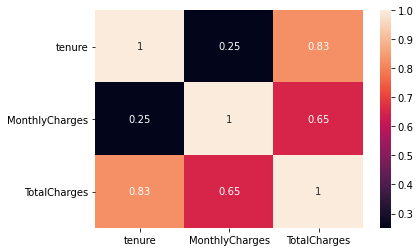

In [21]:
sns.heatmap(data.corr(), annot = True)

In [22]:
# from statsmodels.formula.api import ols

# model = ols('Churn ~ tenure +TotalCharges+MonthlyCharges', data)
# res = model.fit()
# res.summary()

In [23]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
#              for i, column in enumerate(model.exog_names)
#              if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

In [24]:
cat_list = list(data.select_dtypes(include =['object']))
cat_list

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

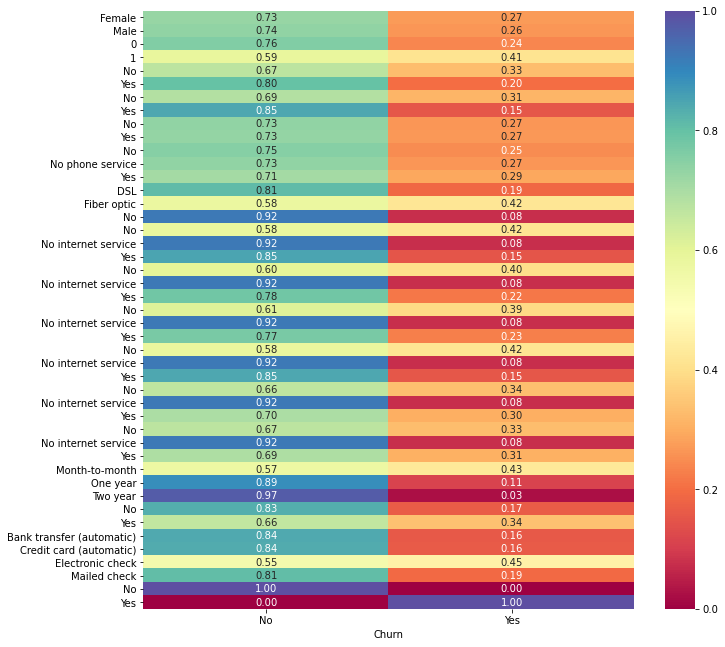

In [25]:
att_by_cat = pd.crosstab(data.Churn, data.gender, normalize='columns')

for i in cat_list[2:]:
    t = pd.crosstab(data.Churn, data[i], normalize='columns')
    att_by_cat = pd.concat((att_by_cat, t), axis=1)
    
f, a = plt.subplots(figsize=(11, 11))
heat = sns.heatmap(att_by_cat.transpose(), annot=True, fmt=".2f", center=.5, cmap="Spectral")

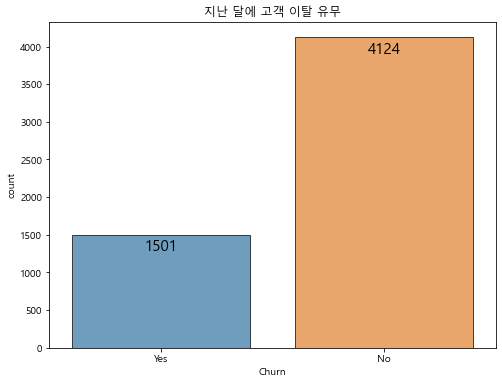

In [26]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

plt.figure(figsize = (8,6))
splot = sns.countplot(data["Churn"], edgecolor="black",alpha=0.7)  # alpha를 이용하여 색 조정 
plt.title("지난 달에 고객 이탈 유무")


for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

In [27]:
X = X_train.drop(["Churn"],axis = 1)
y = X_train["Churn"]

y.replace("No",0,inplace = True)
y.replace("Yes",1,inplace = True)

In [28]:
y.value_counts()/len(y)

0    0.733156
1    0.266844
Name: Churn, dtype: float64

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify = y,test_size = 0.2, shuffle = True, random_state = 20171490)

In [30]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(4500, 20)
(1125, 20)
(4500,)
(1125,)


In [31]:
print(y_train.value_counts()/len(y_train))
print(y_valid.value_counts()/len(y_valid))

0    0.733111
1    0.266889
Name: Churn, dtype: float64
0    0.733333
1    0.266667
Name: Churn, dtype: float64


In [32]:
print(y_train.value_counts())
print(y_valid.value_counts())

0    3299
1    1201
Name: Churn, dtype: int64
0    825
1    300
Name: Churn, dtype: int64


In [33]:
cate_features2 = []
cate_features_not2 = []

for column in X_train.columns:
    if X_train[column].dtypes==object:
        if len(X_train[column].value_counts())==2:
            cate_features2.append(column)
        else:
            cate_features_not2.append(column)
        
print(cate_features2)
print(cate_features_not2)

cate_features_not2.remove("customerID")

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [34]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [35]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure","MonthlyCharges"])),
        ('scaler', MinMaxScaler()),
    ])

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(cate_features_not2)),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(cate_features2)),
        ('ordinary', OrdinalEncoder()),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])

X_prepared = preprocess_pipeline.fit_transform(X_train)

In [36]:
pd.DataFrame(X_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,1.000000,0.785750,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,0.647887,0.020429,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.985915,0.668161,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,0.000000,0.674141,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.267606,0.704534,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0.000000,0.312905,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4496,0.140845,0.675635,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4497,1.000000,0.736423,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4498,0.478873,0.780767,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


#### 파이프라인 적용 후 feature 확인

In [37]:
feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

[array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

In [38]:
feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

cat_one_hot_features = []

i = 0

for feature in cate_features_not2:
        
    cat_one_hot_features.append([feature+"_"+string for string in list(feature_names.categories_[i])])    

    i += 1
    
cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features =  ["tenure","MonthlyCharges"]+cat_one_hot_features+ cate_features2 
print()
print(len(features))

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

39


In [39]:
X_prepared.shape

(4500, 39)

### 여러 모델 적용하여 비교하기 

In [40]:
models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","Ada","XGB"]

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

acc = []
precision = []
recall = []
roc = []

for model, name in zip(models, names):
    print(name)
    cv_predict = cross_val_predict(model, X_prepared, y_train,cv=cv_mo)

    acc.append(accuracy_score(y_train, cv_predict))
    precision.append(precision_score(y_train,cv_predict))
    recall.append(recall_score(y_train,cv_predict))
    roc.append(roc_auc_score(y_train, cv_predict))
    
pd.DataFrame({"Model":names, "Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc})

Logistic
RF
Ada
XGB
[21:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:55:16] WARNING: C:/Users/Administrator/workspa

,Model,Accuracy,Precision,Recall,AUC
0,Logistic,0.808444,0.669331,0.557868,0.728768
1,RF,0.794444,0.648387,0.502082,0.701480
2,Ada,0.804667,0.662626,0.546211,0.722484
3,XGB,0.786444,0.618577,0.521232,0.702114


AdaBoost와 Logistic의 성능이 가장 좋음

#### 랜덤포레스트기로 중요 변수 확인

In [41]:
feature_importances = pd.DataFrame(RandomForestClassifier().fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
tenure,0.201140
MonthlyCharges,0.195071
Contract_Month-to-month,0.065136
OnlineSecurity_No,0.036622
gender,0.033160
PaymentMethod_Electronic check,0.031116
TechSupport_No,0.031069
PaperlessBilling,0.028929
Partner,0.027910
InternetService_Fiber optic,0.025910


<AxesSubplot:xlabel='importance'>

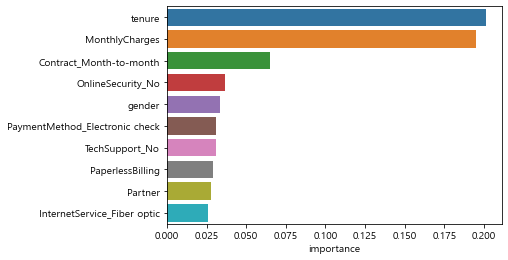

In [42]:
sns.barplot(feature_importances["importance"],feature_importances.index)

#### 보조 서비스 가입 개수 변수 추가하기
보조서비스 종류: OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport   
스트리밍: StreamingTV, StreamingMovies

In [43]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names): # *args 또는 **kargs 없음
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        
        df = X[self.attribute_names]
        df.replace("Yes",1,inplace=True)
        df.replace("No",0,inplace=True)
        df.replace("No internet service",0,inplace=True)
    
        df["SupplementaryService"] = df["OnlineSecurity"]+df["OnlineBackup"]+df["DeviceProtection"]+df["TechSupport"]
        df["Streaming"] = df["StreamingTV"]+df["StreamingMovies"]

        return df.drop(self.attribute_names, axis = 1)

In [44]:
col_names = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
df_extra_attribs = CombinedAttributesAdder(col_names)
df_extra_attribs.transform(X_train)

,SupplementaryService,Streaming
4816,1,2
1695,0,0
2384,3,2
2740,0,1
6791,1,1
...,...,...
1938,0,0
5138,0,1
6650,4,2
5089,4,0


#### 파생변수가 유의미한 변수일 것인지 확인

In [45]:
check_data = pd.concat([df_extra_attribs.transform(X_train),y_train],axis=1)

In [46]:
check_data

,SupplementaryService,Streaming,Churn
4816,1,2,0
1695,0,0,0
2384,3,2,0
2740,0,1,1
6791,1,1,0
...,...,...,...
1938,0,0,0
5138,0,1,0
6650,4,2,0
5089,4,0,0


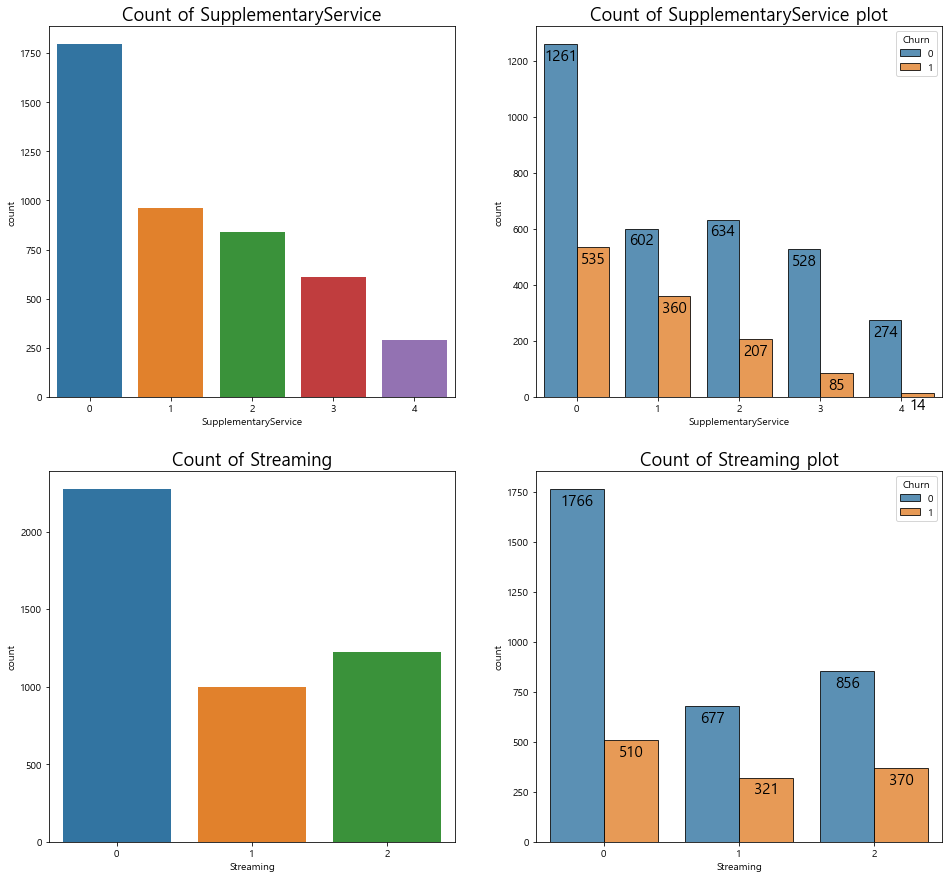

In [47]:
f, ax = plt.subplots(2,2,figsize=[16,15])

for i, cn in enumerate(check_data[["SupplementaryService","Streaming"]]):
    sns.countplot(check_data[cn], ax = ax[i,0])
    ax[i,0].set_title("Count of "+cn, fontsize = 18)
    
    splot = sns.countplot(check_data[cn],data = check_data,hue = "Churn", edgecolor="black",alpha=0.8,ax = ax[i, 1])
    ax[i,1].set_title("Count of "+cn+" plot", fontsize = 18)
    
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=15,
                       xytext = (0, -12), 
                       textcoords = 'offset points')

plt.show()

In [48]:
data["PaymentMethod"].value_counts()

Electronic check             1893
Mailed check                 1281
Bank transfer (automatic)    1233
Credit card (automatic)      1218
Name: PaymentMethod, dtype: int64

In [49]:
data["Contract"].value_counts()

Month-to-month    3100
Two year          1318
One year          1207
Name: Contract, dtype: int64

In [50]:
cate_features2

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

In [51]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure", "MonthlyCharges"])),
        ('scaler', MinMaxScaler()),
    ])

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'])),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_no_cor_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling'])),
        # ("select_cate_ord", DataFrameSelector(cate_features2)),

        ('ordinary', OrdinalEncoder()),
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(cate_features2)),

        ('ordinary', OrdinalEncoder()),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])

preprocess_no_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_no_cor_pipeline)])

X_prepared = preprocess_pipeline.fit_transform(X_train)
X_prepared_no = preprocess_no_pipeline.fit_transform(X_train)

In [52]:
print(X_prepared.shape)
print(X_prepared_no.shape)

(4500, 23)
(4500, 21)


In [53]:
X_valid_prepared = preprocess_pipeline.fit_transform(X_valid)
X_valid_prepared_no = preprocess_no_pipeline.fit_transform(X_valid)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def Modeling_result(train_x, train_y, valid_x, valid_y):
    
    models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
    names = ["Logistic","RF","Ada","XGB"]

    train_acc = []
    train_precision = []
    train_recall = []
    train_roc = []

    valid_acc = []
    valid_precision = []
    valid_recall = []
    valid_roc = []


    for model, name in zip(models, names):

        model.fit(train_x,train_y)
        model.predict(valid_x)

        train_acc.append(accuracy_score(train_y,model.predict(train_x)))
        train_precision.append(precision_score(train_y,model.predict(train_x)))
        train_recall.append(recall_score(train_y,model.predict(train_x)))
        train_roc.append(roc_auc_score(train_y, model.predict(train_x)))

        valid_acc.append(accuracy_score(valid_y, model.predict(valid_x)))
        valid_precision.append(precision_score(valid_y,model.predict(valid_x)))
        valid_recall.append(recall_score(valid_y,model.predict(valid_x)))
        valid_roc.append(roc_auc_score(valid_y, model.predict(valid_x)))
        
    return pd.DataFrame({"Model":names, "Train_Accuracy":train_acc, "Train_Precision":train_precision, "Train_Recall":train_recall, "Train_AUC":train_roc,
             "Valid_Accuracy":valid_acc, "Valid_Precision":valid_precision, "Valid_Recall":valid_recall, "Valid_AUC":valid_roc})


In [55]:
gender_right = Modeling_result(X_prepared, y_train, X_valid_prepared, y_valid)
gender_right

[21:55:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.809778,0.673367,0.557868,0.729677,0.793778,0.633858,0.536667,0.711970
1,RF,0.997778,0.995837,0.995837,0.997161,0.776000,0.607143,0.453333,0.673333
2,Ada,0.809333,0.675897,0.548709,0.726461,0.789333,0.634043,0.496667,0.696212
3,XGB,0.940000,0.929825,0.838468,0.907715,0.755556,0.550607,0.453333,0.659394


In [56]:
no_cor_result = Modeling_result(X_prepared_no, y_train, X_valid_prepared_no, y_valid)
no_cor_result

[21:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.810222,0.674022,0.559534,0.730510,0.792889,0.631373,0.536667,0.711364
1,RF,0.996889,0.995823,0.992506,0.995495,0.782222,0.619048,0.476667,0.685000
2,Ada,0.809333,0.675897,0.548709,0.726461,0.789333,0.634043,0.496667,0.696212
3,XGB,0.928000,0.899727,0.821815,0.894236,0.766222,0.570881,0.496667,0.680455


* RF와 XG는 과대적합이 발생함.
    * feature 수를 줄이거나 규제를 줄인다. -> feature 수 줄이는 것을 선택 
    * gender, PhoneService 변수는 독립성 검정 시 상관없는 변수이기 때문에 제외해본 결과 검증 셋에 더 좋은 성능을 띈다.
    
* Logistic, Ada를 대상으로 교차검증을 적용


#### Logisitc, AdaBoost 모델 교차 검증 적용하기

In [57]:
cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

cv_predict = cross_val_predict(LogisticRegression(), preprocess_pipeline.fit_transform(X), y,cv=cv_mo)
print(classification_report(y, cv_predict))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4124
           1       0.66      0.55      0.60      1501

    accuracy                           0.81      5625
   macro avg       0.75      0.72      0.74      5625
weighted avg       0.80      0.81      0.80      5625



In [58]:
cv_predict = cross_val_predict(AdaBoostClassifier(), preprocess_pipeline.fit_transform(X), y,cv=cv_mo)
print(classification_report(y, cv_predict))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4124
           1       0.66      0.54      0.59      1501

    accuracy                           0.80      5625
   macro avg       0.75      0.72      0.73      5625
weighted avg       0.79      0.80      0.80      5625



Recall 의 성능이 너무 낮음.

### 데이터 불균형 해소

In [59]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 20171490)

X_res_train, y_res_train = sm.fit_sample(X_prepared_no, y_train)
print(y_train.value_counts(), np.bincount(y_res_train))

0    3299
1    1201
Name: Churn, dtype: int64 [3299 3299]


In [60]:
upsampling_result = Modeling_result(X_res_train, y_res_train, X_valid_prepared_no, y_valid)
upsampling_result

[21:55:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.769779,0.758420,0.791755,0.769779,0.729778,0.495690,0.766667,0.741515
1,RF,0.998030,0.997577,0.998484,0.998030,0.764444,0.560554,0.540000,0.693030
2,Ada,0.808578,0.786922,0.846317,0.808578,0.739556,0.508197,0.723333,0.734394
3,XGB,0.944983,0.940841,0.949682,0.944983,0.753778,0.535385,0.580000,0.698485


전체 train 데이터를 대상으로 교차 검증

In [61]:
X_res, y_res = sm.fit_sample(preprocess_no_pipeline.fit_transform(X), y)
print(y_train.value_counts(), np.bincount(y_res))

0    3299
1    1201
Name: Churn, dtype: int64 [4124 4124]


In [62]:
models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","Ada","XGB"]
cv_scores = []

acc = []
precision = []
recall = []
roc = []

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, X_res, y_res, cv=10)
    cv_scores.append(cross_val_score(model, X_res, y_res, cv=10,scoring='roc_auc'))

    acc.append(accuracy_score(y_res, cv_predict))
    precision.append(precision_score(y_res,cv_predict))
    recall.append(recall_score(y_res,cv_predict))
    roc.append(roc_auc_score(y_res, cv_predict))
    
pd.DataFrame({"Model":names, "Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc})

Logistic
RF
Ada
XGB
[21:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:55:52] WARNING: C:/Users/Administrator/workspa

,Model,Accuracy,Precision,Recall,AUC
0,Logistic,0.766125,0.752589,0.792919,0.766125
1,RF,0.852692,0.842316,0.867847,0.852692
2,Ada,0.801164,0.778351,0.842144,0.801164
3,XGB,0.841295,0.837773,0.846508,0.841295


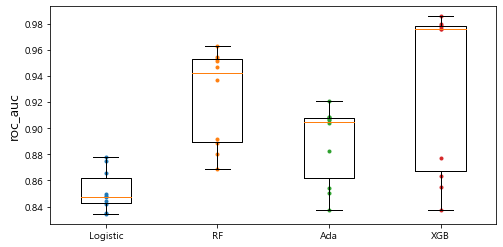

In [63]:
plt.figure(figsize=(8, 4))

i = 1

for cv_score in cv_scores:
    
    plt.plot([i]*10, cv_score, ".")
    
    i+=1
    
plt.boxplot(cv_scores, labels=("Logistic","RF","Ada","XGB"))
plt.ylabel("roc_auc", fontsize=14)
plt.show()

#### RandomForest grid search

In [65]:
param_grid_RF = {
    "n_estimators" :[10,15,20,25], 
    "max_depth" : [5,10,15],
    "min_samples_split":[2,4,8,16],
    "max_features":["sqrt","auto","log2"],
    "class_weight" : ["balanced_subsample","balanced"]}

cv_RF_roc = GridSearchCV(RandomForestClassifier(),param_grid_RF, cv= 10, scoring = "roc_auc",return_train_score=True)
cv_RF_roc.fit(X_res, y_res)
cv_RF_best = cv_RF_roc.best_estimator_

In [66]:
cv_RF_roc.best_params_

{'class_weight': 'balanced',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 25}

In [82]:
param = cv_RF_roc.best_params_
model_RF = RandomForestClassifier(class_weight = "balanced",max_depth = 20, max_features = 'auto', min_samples_split = 2, n_estimators = 25, random_state = 20171490)

# method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
cv_predict = cross_val_predict(model_RF, X_res, y_res, cv=10)

acc = accuracy_score(y_res, cv_predict)
precision = precision_score(y_res,cv_predict)
recall = recall_score(y_res,cv_predict)
roc =roc_auc_score(y_res, cv_predict)

pd.DataFrame([{"Model":"RF_gradient","Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc}])

,Model,Accuracy,Precision,Recall,AUC
0,RF_gradient,0.850509,0.836397,0.871484,0.850509


<AxesSubplot:>

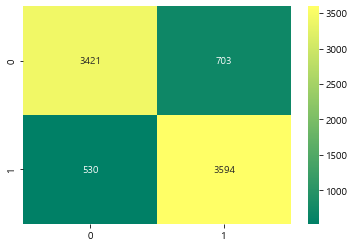

In [83]:
sns.heatmap(confusion_matrix(y_res,cv_predict),annot=True,fmt='3.0f',cmap="summer")

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

21


<AxesSubplot:xlabel='importance'>

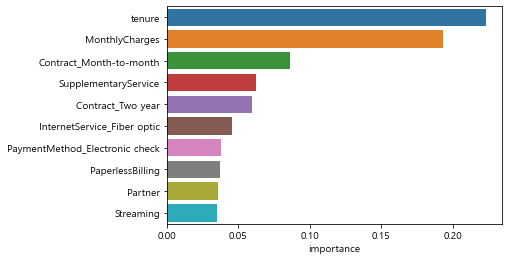

In [84]:
feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

cat_one_hot_features = []

i = 0

for feature in ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']:
        
    cat_one_hot_features.append([feature+"_"+string for string in list(feature_names.categories_[i])])    

    i += 1
    
cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features =  ["SupplementaryService", "Streaming"] + ["tenure","MonthlyCharges"] + cat_one_hot_features + ['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling']
print()
print(len(features))

feature_importances = pd.DataFrame(model_RF.fit(X_res,y_res).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

sns.barplot(feature_importances["importance"],feature_importances.index)

In [85]:
param = cv_RF_roc.best_params_
model_RF = RandomForestClassifier(class_weight = "balanced", max_depth = 15, max_features = 'auto', min_samples_split = 2, n_estimators = 25)

model_RF.fit(X_res_train, y_res_train)
print(confusion_matrix(y_res_train,model_RF.predict(X_res_train)))
print(classification_report(y_res_train,model_RF.predict(X_res_train)))

print(confusion_matrix(y_valid,model_RF.predict(X_valid_prepared_no)))
print(classification_report(y_valid,model_RF.predict(X_valid_prepared_no)))

[[3076  223]
 [  30 3269]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3299
           1       0.94      0.99      0.96      3299

    accuracy                           0.96      6598
   macro avg       0.96      0.96      0.96      6598
weighted avg       0.96      0.96      0.96      6598

[[677 148]
 [109 191]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       825
           1       0.56      0.64      0.60       300

    accuracy                           0.77      1125
   macro avg       0.71      0.73      0.72      1125
weighted avg       0.78      0.77      0.78      1125



* 훈련 데이터와 검증 데이터 각각의 성능을 비교-> 과대적합 발생

In [86]:
param = cv_RF_roc.best_params_
model_RF = RandomForestClassifier(class_weight = "balanced", max_depth = 8, max_features = 'auto', min_samples_split = 2, n_estimators = 25)

model_RF.fit(X_res_train, y_res_train)
print(confusion_matrix(y_res_train,model_RF.predict(X_res_train)))
print(classification_report(y_res_train,model_RF.predict(X_res_train)))

print(confusion_matrix(y_valid,model_RF.predict(X_valid_prepared_no)))
print(classification_report(y_valid,model_RF.predict(X_valid_prepared_no)))

[[2589  710]
 [ 324 2975]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      3299
           1       0.81      0.90      0.85      3299

    accuracy                           0.84      6598
   macro avg       0.85      0.84      0.84      6598
weighted avg       0.85      0.84      0.84      6598

[[625 200]
 [ 83 217]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       825
           1       0.52      0.72      0.61       300

    accuracy                           0.75      1125
   macro avg       0.70      0.74      0.71      1125
weighted avg       0.79      0.75      0.76      1125



In [87]:
param = cv_RF_roc.best_params_
model_RF = RandomForestClassifier(class_weight = "balanced",max_depth = 8, max_features = 'auto', min_samples_split = 2, n_estimators = 25)

# method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
cv_predict = cross_val_predict(model_RF, X_res, y_res, cv=10)

acc = accuracy_score(y_res, cv_predict)
precision = precision_score(y_res,cv_predict)
recall = recall_score(y_res,cv_predict)
roc =roc_auc_score(y_res, cv_predict)

pd.DataFrame([{"Model":"RF_gradient","Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc}])

,Model,Accuracy,Precision,Recall,AUC
0,RF_gradient,0.807226,0.774837,0.866149,0.807226


max_depth 조절 후 교차검증결과 따로 만들어둔 검증 데이터셋에만 일반화가 잘된 것으로 보임. 

### AutoMl 적용

In [64]:
from pycaret.classification import *

pycaret는 기존에 있던 sklearn, XGBoost, LigthGBM, spaCy 등 여러가지 머신러닝 라이브러리를 사용하기 용이하도록 제적한 라이브러리.

In [65]:
ml_data = pd.concat([pd.DataFrame(X_res),y_res],axis=1)
ml_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,Churn
0,0.000000,0.000000,0.225352,0.514200,1.0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,1.000000,1
1,0.000000,0.000000,0.126761,0.515695,1.0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0
2,2.000000,0.000000,0.704225,0.157449,0.0,1.0,0.0,1.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,0.0,1.000000,1.0,0.000000,0
3,0.000000,0.000000,0.295775,0.016442,1.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0
4,1.000000,0.000000,0.098592,0.564026,1.0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,1.000000,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,3.941552,1.058448,0.943752,0.618917,0.0,0.0,1.0,0.941552,0.058448,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,1
8244,1.000000,2.000000,0.233881,0.818938,0.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,1.000000,1.0,0.316409,1
8245,2.000000,2.000000,0.324866,0.857017,0.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.213094,0.786906,0.0,0.000000,0.0,1.000000,1
8246,0.000000,0.000000,0.092490,0.252398,1.0,0.0,0.0,1.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.570845,0.0,1.000000,1


In [66]:
# setup 메서드를 이용하여 데이터에 대한 여러가지 머신러닝 기법 사용 가능
# 객체 선언 후 실행한 후 ENRTER를 누름. 

clf = setup(data = ml_data, target = "Churn")  # train_size = 0.7 (default)

,Description,Value
0,session_id,3757
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(8248, 22)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [89]:
# model()  # 사용가능한 머신러닝 모델 확인 가능 
# 파라미터 이름, 머신러닝 기법이름, 사이킷런 API 사용 여부 등 
# create_model('lr')  # LinearRegression 모델 생성 
# tune_model()  # 생성한 모델 튜닝 

In [67]:
best_3 = compare_models(sort = 'AUC', n_select = 3)  # 모델 성능 비교 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8488,0.9280,0.8617,0.8415,0.8512,0.6975,0.6982,6.7770
xgboost,Extreme Gradient Boosting,0.8425,0.9263,0.8565,0.8348,0.8452,0.6850,0.6859,0.6350
lightgbm,Light Gradient Boosting Machine,0.8392,0.9253,0.8579,0.8286,0.8427,0.6784,0.6794,0.2190
gbc,Gradient Boosting Classifier,0.8282,0.9116,0.8634,0.8082,0.8347,0.6562,0.6582,0.2010
rf,Random Forest Classifier,0.8341,0.9100,0.8489,0.8261,0.8371,0.6681,0.6688,0.3080
et,Extra Trees Classifier,0.8353,0.9076,0.8541,0.8248,0.8389,0.6705,0.6714,0.3290
ada,Ada Boost Classifier,0.7999,0.8868,0.8434,0.7774,0.8088,0.5997,0.6023,0.0840
lr,Logistic Regression,0.7679,0.8541,0.7961,0.7550,0.7748,0.5356,0.5369,1.5300
lda,Linear Discriminant Analysis,0.7707,0.8535,0.8179,0.7487,0.7815,0.5411,0.5439,0.0190
knn,K Neighbors Classifier,0.7694,0.8475,0.8548,0.7318,0.7883,0.5386,0.5470,0.0820


In [68]:
tuned_top3 = [tune_model(i) for i in best_3]
tuned_top3

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8564,0.9346,0.8586,0.8557,0.8571,0.7128,0.7128
1,0.8443,0.9226,0.8552,0.8378,0.8464,0.6886,0.6887
2,0.8547,0.9365,0.8966,0.8280,0.8609,0.7093,0.7117
3,0.8510,0.9391,0.8517,0.8517,0.8517,0.7019,0.7019
4,0.8388,0.9269,0.8517,0.8316,0.8416,0.6776,0.6778
5,0.8423,0.9300,0.8655,0.8284,0.8465,0.6845,0.6852
6,0.8302,0.9274,0.8172,0.8404,0.8287,0.6604,0.6606
7,0.8544,0.9356,0.9034,0.8239,0.8618,0.7087,0.7120
8,0.8146,0.9123,0.8103,0.8188,0.8146,0.6291,0.6292
9,0.8163,0.9000,0.8235,0.8123,0.8179,0.6326,0.6326


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.245, max_delta_step=0, max_depth=7,
               min_child_weight=4, missing=nan, monotone_constraints='()',
               n_estimators=260, n_jobs=-1, num_parallel_tree=1,
               objective='binary:logistic', random_state=3757, reg_alpha=0.05,
               reg_lambda=3, scale_pos_weight=48.2, subsample=1,
               tree_method='auto', use_label_encoder=True, validate_parameters=1,
               verbosity=0),
 LGBMClassifier(bagging_fraction=0.9, bagging_freq=7, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
                importance_type='split', learning_rate=0.217, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.4,
           

In [69]:
blender = blend_models(estimator_list = best_3,fold = 10, method = 'soft') 
blender

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8806,0.9432,0.8828,0.8797,0.8812,0.7612,0.7612
1,0.8478,0.9247,0.8655,0.8367,0.8508,0.6955,0.6959
2,0.8737,0.9408,0.8966,0.8581,0.8769,0.7474,0.7481
3,0.8666,0.9360,0.8517,0.8790,0.8651,0.7331,0.7335
4,0.8284,0.9259,0.8448,0.8194,0.8319,0.6568,0.6571
5,0.8475,0.9309,0.8759,0.8301,0.8523,0.6949,0.6959
6,0.8440,0.9334,0.8310,0.8546,0.8427,0.6881,0.6883
7,0.8510,0.9385,0.9069,0.8168,0.8595,0.7017,0.7061
8,0.8180,0.9176,0.8172,0.8201,0.8187,0.6360,0.6360
9,0.8284,0.9079,0.8478,0.8167,0.8319,0.6568,0.6573


TunableVotingClassifier(estimators=[('catboost',
                                     <catboost.core.CatBoostClassifier object at 0x000001F644326748>),
                                    ('xgboost',
                                     XGBClassifier(base_score=0.5,
                                                   booster='gbtree',
                                                   colsample_bylevel=1,
                                                   colsample_bynode=1,
                                                   colsample_bytree=1, gamma=0,
                                                   gpu_id=-1,
                                                   importance_type='gain',
                                                   interaction_constraints='',
                                                   learning_rate=0.300000012,
                                                   max_delta_step=0,
                                                   max_depth=6,
              

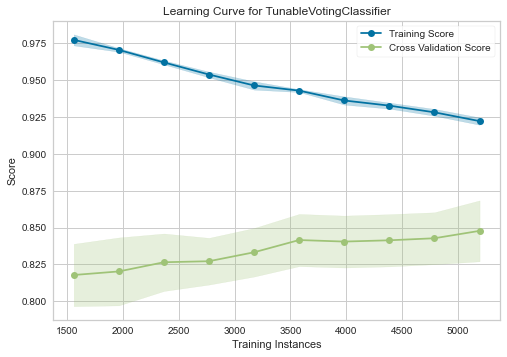

In [70]:
plot_model(estimator = blender, plot = 'learning')

In [85]:
# plot_model(estimator = blender, plot = 'feature')   # tree모형을 사용할 때 

In [71]:
evaluate_model(estimator=blender)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [78]:
stacker = stack_models(estimator_list=tuned_top3, fold = 10)
stacker

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8651,0.9388,0.8690,0.8630,0.8660,0.7301,0.7301
1,0.8391,0.9235,0.8414,0.8385,0.8399,0.6782,0.6782
2,0.8668,0.9425,0.9069,0.8403,0.8723,0.7335,0.7358
3,0.8562,0.9340,0.8586,0.8557,0.8571,0.7123,0.7123
4,0.8440,0.9310,0.8517,0.8401,0.8459,0.6880,0.6881
5,0.8510,0.9348,0.8759,0.8355,0.8552,0.7018,0.7027
6,0.8458,0.9323,0.8310,0.8577,0.8441,0.6915,0.6919
7,0.8440,0.9414,0.9034,0.8086,0.8534,0.6878,0.6927
8,0.8250,0.9179,0.8207,0.8293,0.8250,0.6499,0.6500
9,0.8336,0.9043,0.8512,0.8227,0.8367,0.6672,0.6676


StackingClassifier(cv=StratifiedKFold(n_splits=10, random_state=3757, shuffle=False),
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001F644C73B08>),
                               ('xgboost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.9, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints...
                                               subsample_for_bin=200000,
                                               subsample_freq=0))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False

In [72]:
# final_model = finalize_model(blender)   # 전체 데이터를 재학습

In [73]:
y_test = X_test["Churn"]
X_test = X_test.drop(["Churn"],axis = 1)

In [74]:
X_prepared_test = preprocess_no_pipeline.fit_transform(X_test)

y_test.replace("Yes",1,inplace = True)
y_test.replace("No",0,inplace = True)

In [75]:
# pred_holdout = predict_model(final_model, data = pd.DataFrame(X_prepared_test))   # test 데이터에 예측 

In [133]:
model_RF = RandomForestClassifier(class_weight = "balanced",max_depth = 8, max_features = 'auto', min_samples_split = 2, n_estimators = 25, random_state = 42)
model_RF.fit(X_res, y_res)
y_pred = model_RF.predict(X_prepared_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
roc =roc_auc_score(y_test, y_pred)

pd.DataFrame([{"Model":"RF_test","Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc}])

,Model,Accuracy,Precision,Recall,AUC
0,RF_test,0.761194,0.528674,0.80163,0.774251


<AxesSubplot:>

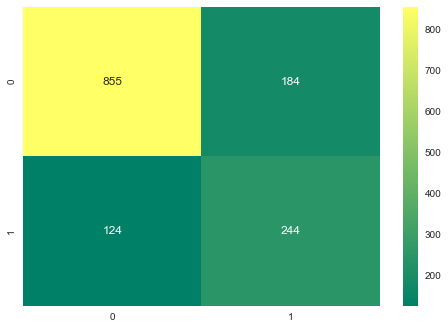

In [134]:
sns.heatmap(confusion_matrix(y_test,pred_holdout["Label"]),annot=True,fmt='3.0f',cmap="summer")

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1039
           1       0.53      0.80      0.64       368

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407



['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

21


<AxesSubplot:xlabel='importance'>

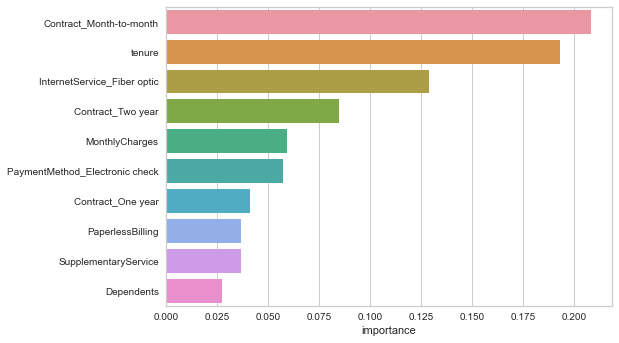

In [136]:
feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

cat_one_hot_features = []

i = 0

for feature in ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']:
        
    cat_one_hot_features.append([feature+"_"+string for string in list(feature_names.categories_[i])])    

    i += 1
    
cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features =  ["SupplementaryService", "Streaming"] + ["tenure","MonthlyCharges"] + cat_one_hot_features + ['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling']
print()
print(len(features))

feature_importances = pd.DataFrame(model_RF.fit(X_res,y_res).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

sns.barplot(feature_importances["importance"],feature_importances.index)

In [138]:
import joblib

joblib.dump(model_RF,"./model_RF.pkl")

['./model_RF.pkl']

---

### 참고

In [56]:
train_data = pd.concat([pd.DataFrame(X_prepared_no).reset_index(drop=True),pd.DataFrame(y_train).reset_index(drop=True)],axis = 1)

In [57]:
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,Churn
0,1.0,2.0,0.914894,0.487220,1.692905,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0
1,0.0,0.0,0.382979,-0.902511,-0.132256,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3.0,2.0,0.893617,0.273694,1.447515,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
3,0.0,1.0,-0.595745,0.284551,-0.384929,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1
4,1.0,1.0,-0.191489,0.339742,0.143799,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0.0,0.0,-0.595745,-0.371409,-0.395617,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4496,0.0,1.0,-0.382979,0.287265,-0.146939,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4497,4.0,2.0,0.914894,0.397648,1.571072,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4498,4.0,0.0,0.127660,0.478172,0.593197,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [58]:
clf = setup(data = train_data, target = "Churn")

,Description,Value
0,session_id,2080
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(4500, 23)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,17
8,Ordinal Features,False
9,High Cardinality Features,False


In [59]:
best_3 = compare_models(sort = 'Recall', n_select = 3)  # 모델 성능 비교 
best_3

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7323,0.8270,0.8076,0.5006,0.6176,0.4290,0.4585,0.0170
lda,Linear Discriminant Analysis,0.7983,0.8346,0.5571,0.6423,0.5950,0.4620,0.4651,0.0190
lr,Logistic Regression,0.8022,0.8435,0.5428,0.6576,0.5924,0.4640,0.4690,1.9190
gbc,Gradient Boosting Classifier,0.7977,0.8415,0.5155,0.6562,0.5754,0.4456,0.4523,0.1360
ada,Ada Boost Classifier,0.7958,0.8439,0.5143,0.6523,0.5733,0.4419,0.4484,0.0740
et,Extra Trees Classifier,0.7663,0.7773,0.5131,0.5672,0.5374,0.3821,0.3837,0.2520
knn,K Neighbors Classifier,0.7685,0.7747,0.5119,0.5766,0.5403,0.3869,0.3893,0.0770
ridge,Ridge Classifier,0.7980,0.0000,0.5083,0.6593,0.5722,0.4434,0.4508,0.0150
xgboost,Extreme Gradient Boosting,0.7745,0.8175,0.5072,0.5920,0.5454,0.3970,0.3996,0.6720
dt,Decision Tree Classifier,0.7323,0.6605,0.5048,0.4994,0.5009,0.3185,0.3190,0.0170


[GaussianNB(priors=None, var_smoothing=1e-09),
 LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                            solver='svd', store_covariance=False, tol=0.0001),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=2080, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)]

In [63]:
# tune top 5 base models
tuned_top3 = [tune_model(i) for i in best_3]
tuned_top3

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8317,0.8906,0.6190,0.7123,0.6624,0.5511,0.5535
1,0.7778,0.8315,0.4762,0.6061,0.5333,0.3902,0.3951
2,0.8095,0.8436,0.6071,0.6538,0.6296,0.5017,0.5023
3,0.7810,0.8132,0.4048,0.6415,0.4964,0.3654,0.3812
4,0.7841,0.8282,0.5357,0.6081,0.5696,0.4263,0.4278
5,0.8127,0.8751,0.5952,0.6667,0.6289,0.5042,0.5056
6,0.8032,0.8526,0.6190,0.6341,0.6265,0.4929,0.4930
7,0.8317,0.8458,0.5647,0.7500,0.6443,0.5370,0.5462
8,0.7937,0.8295,0.5059,0.6515,0.5695,0.4366,0.4427
9,0.7994,0.8281,0.5238,0.6567,0.5828,0.4529,0.4579


[GaussianNB(priors=None, var_smoothing=1),
 LinearDiscriminantAnalysis(n_components=None, priors=None,
                            shrinkage='empirical', solver='lsqr',
                            store_covariance=False, tol=0.0001),
 LogisticRegression(C=8.392, class_weight={}, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=2080, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)]

In [64]:
stacker = stack_models(estimator_list=tuned_top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8317,0.8908,0.6190,0.7123,0.6624,0.5511,0.5535
1,0.7778,0.8313,0.4643,0.6094,0.5270,0.3852,0.3913
2,0.8095,0.8429,0.6071,0.6538,0.6296,0.5017,0.5023
3,0.7746,0.8131,0.3929,0.6226,0.4818,0.3470,0.3621
4,0.7841,0.8271,0.5357,0.6081,0.5696,0.4263,0.4278
5,0.8095,0.8752,0.5952,0.6579,0.6250,0.4978,0.4989
6,0.8063,0.8515,0.6190,0.6420,0.6303,0.4992,0.4993
7,0.8254,0.8462,0.5412,0.7419,0.6259,0.5156,0.5265
8,0.7937,0.8261,0.5059,0.6515,0.5695,0.4366,0.4427
9,0.7994,0.8269,0.5119,0.6615,0.5772,0.4484,0.4548


In [65]:
pred_holdout = predict_model(stacker)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8127,0.8502,0.5487,0.6840,0.6090,0.4878,0.4929


Recall이 낮음

샘플링은 해야함.

In [ ]:
y_scores = cross_val_predict(model_Ada, X_prepared, y_train, cv=cv_mo,method="decision_function")

In [636]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
thresholds

In [638]:
len(thresholds)

2

In [639]:
precision_90_recall = precisions[np.argmax(recalls >= 0.90)]
threshold_90_precision = thresholds[np.argmax(recalls >= 0.90)]

In [640]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center left", fontsize=10) 
    plt.xlabel("Threshold", fontsize=13)        
    plt.grid(True)                              
    plt.axis([-20, 5, 0, 1])             

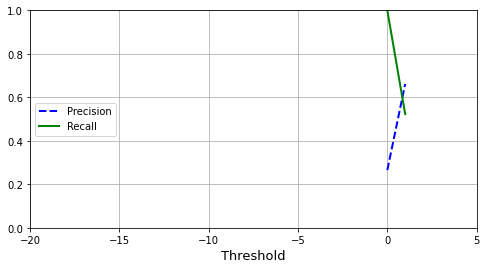

In [641]:
plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

0.6615905245346869
0.5230769230769231


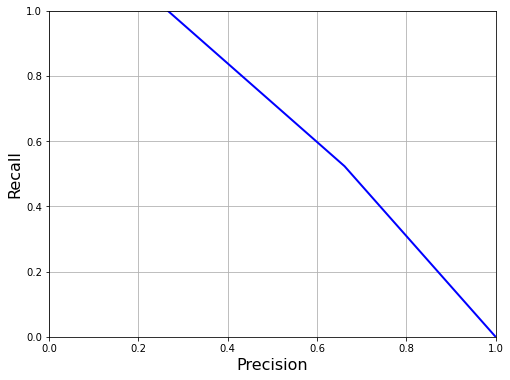

In [642]:
import matplotlib.pyplot as plt

def plot_precision_vs_recall(recalls, precisions):
    plt.plot(precisions,recalls, "b-", linewidth=2)
    plt.xlabel("Precision", fontsize=16)
    plt.ylabel("Recall", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(recalls, precisions)

threshold_80_recall = thresholds[np.argmax(recalls <= 0.80)]
threshold_80_recall

y_train_pred_80 = (y_scores >= threshold_80_recall)

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred_80))
print(recall_score(y_train, y_train_pred_80))

In [709]:
print(cate_features2)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
